In [2]:

import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import pandas as pd
import numba

import finitewave as fw


# number of nodes on the side
n = 400

alphas = np.radians(np.arange(0, 91, 15))
# alphas = np.radians([45])
# loop over different anisotropy coefficients
out = []
images = []
for alpha in alphas:
    tissue = fw.CardiacTissue2D([n, n])
    # add fibers orientation vectors
    tissue.fibers = np.zeros([n, n, 2])
    tissue.fibers[..., 0] = np.cos(alpha)
    tissue.fibers[..., 1] = np.sin(alpha)

    # create model object:
    aliev_panfilov = fw.AlievPanfilov2D()
    # set up numerical parameters:
    aliev_panfilov.dt = 0.01
    aliev_panfilov.dr = 0.25
    aliev_panfilov.t_max = 25
    # set up stimulation parameters:
    stim_sequence = fw.StimSequence()
    stim_sequence.add_stim(fw.StimVoltageCoord2D(0, 1, n//2 - 5, n//2 + 5,
                                                 n//2 - 5, n//2 + 5))
    # add the tissue and the stim parameters to the model object:
    aliev_panfilov.cardiac_tissue = tissue
    aliev_panfilov.stim_sequence = stim_sequence

    aliev_panfilov.run()

    labeled = (aliev_panfilov.u > 0.1).astype(int)
    props = ski.measure.regionprops_table(labeled, properties=(
        'orientation', 'major_axis_length', 'minor_axis_length'))
    props['orientation'] = np.degrees(props['orientation'])
    props['axis_ratio'] = props['major_axis_length'] / props['minor_axis_length']
    props['alpha'] = np.degrees(alpha)
    props['density_calc'] = (np.sum(tissue.mesh[-1:1, -1:1] == 2) 
                                / ((n - 2) * (n - 2)))
    images.append(aliev_panfilov.u.copy())

    out.append(pd.DataFrame(props))

out = pd.concat(out)

Running AlievPanfilov2D:   0%|          | 0/2500 [00:00<?, ?it/s]

Running AlievPanfilov2D: 100%|██████████| 2500/2500 [00:03<00:00, 735.04it/s]


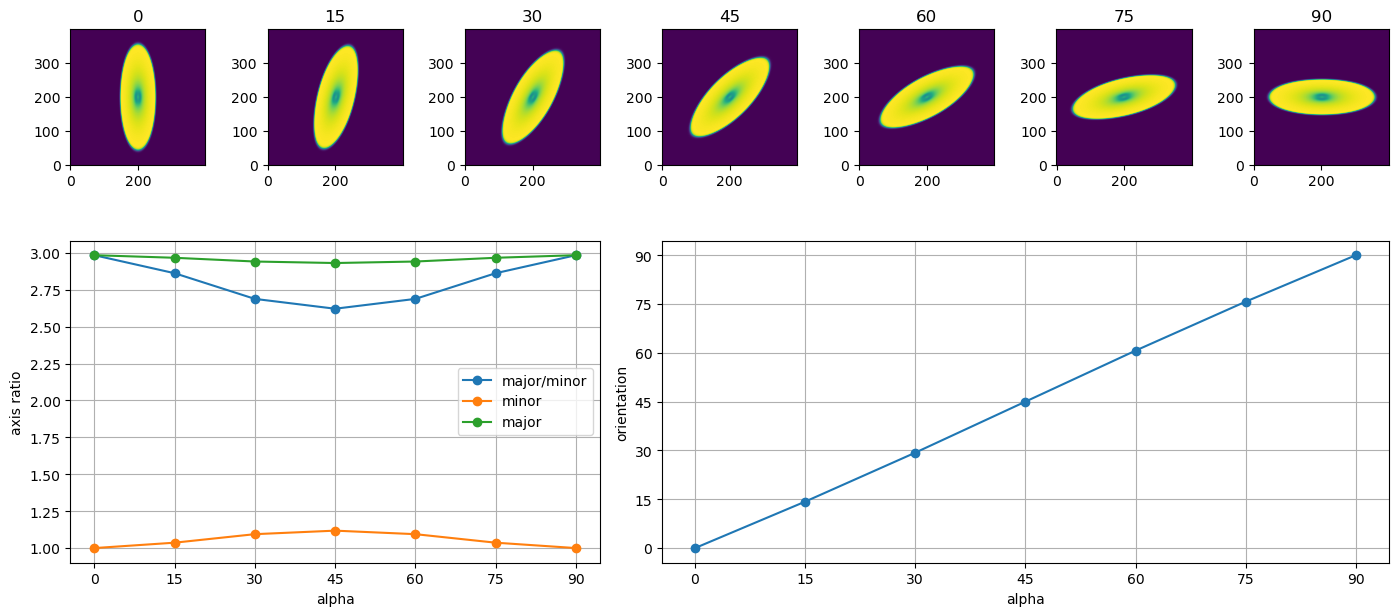

In [3]:

fig, axs = plt.subplot_mosaic([[f'{i}' for i in range(7)],
                               ['axis_ratio'] * 3 + ['orientation']*4],
                               figsize=(14, 7))

for i in range(len(alphas)):
    ax = axs[f'{i}']
    ax.imshow(images[i], cmap='viridis', origin='lower')
    ax.set_title(f'{np.degrees(alphas[i]):.0f}')

ax = axs['axis_ratio']
ax.plot(out['alpha'], out['axis_ratio'], 'o-', label='major/minor')
ax.plot(out['alpha'], out['minor_axis_length'] / out['minor_axis_length'].min(), 'o-', label='minor')
ax.plot(out['alpha'], out['major_axis_length'] / out['minor_axis_length'].min(), 'o-', label='major')
ax.set_xlabel('alpha')
ax.set_ylabel('axis ratio')
ax.set_xticks(np.degrees(alphas))
ax.grid(True)
ax.legend()

ax = axs['orientation']
ax.plot(out['alpha'], out['orientation'], 'o-')
ax.set_xlabel('alpha')
ax.set_ylabel('orientation')
ax.set_xticks(np.degrees(alphas))
ax.set_yticks(np.degrees(alphas))
ax.grid(True)

plt.tight_layout()
plt.show()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import pandas as pd

import finitewave as fw

# number of nodes on the side
n = 400

alphas = np.radians(np.arange(0, 91, 15))
# alphas = np.radians([0, 30, 45])
# loop over different anisotropy coefficients
d = 0.2
out_10 = []
images_10 = []
for alpha in alphas:
    tissue = fw.CardiacTissue2D([n, n])
    tissue.mesh[np.random.random([n, n]) < d] = 2
    tissue.add_boundaries()
    # add fibers orientation vectors
    tissue.fibers = np.zeros([n, n, 2])
    tissue.fibers[..., 0] = np.cos(alpha)
    tissue.fibers[..., 1] = np.sin(alpha)

    # create model object:
    aliev_panfilov = fw.AlievPanfilov2D()
    # set up numerical parameters:
    aliev_panfilov.dt = 0.001
    aliev_panfilov.dr = 0.1
    aliev_panfilov.t_max = 15
    # set up stimulation parameters:
    stim_sequence = fw.StimSequence()
    stim_sequence.add_stim(fw.StimVoltageCoord2D(0, 1, n//2 - 5, n//2 + 5,
                                                 n//2 - 5, n//2 + 5))
    # add the tissue and the stim parameters to the model object:
    aliev_panfilov.cardiac_tissue = tissue
    aliev_panfilov.stim_sequence = stim_sequence

    aliev_panfilov.run()

    labeled = (aliev_panfilov.u > 0.5).astype(int)
    props = ski.measure.regionprops_table(labeled, properties=(
        'orientation', 'major_axis_length', 'minor_axis_length'))
    props['orientation'] = np.degrees(props['orientation'])
    props['axis_ratio'] = props['major_axis_length'] / props['minor_axis_length']
    props['alpha'] = np.degrees(alpha)
    props['density_calc'] = (np.sum(tissue.mesh[-1:1, -1:1] == 2) 
                                / ((n - 2) * (n - 2)))
    images_10.append(aliev_panfilov.u.copy())

    out_10.append(pd.DataFrame(props))

out_10 = pd.concat(out_10)

Running AlievPanfilov2D: 100%|██████████| 15000/15000 [00:19<00:00, 775.13it/s]


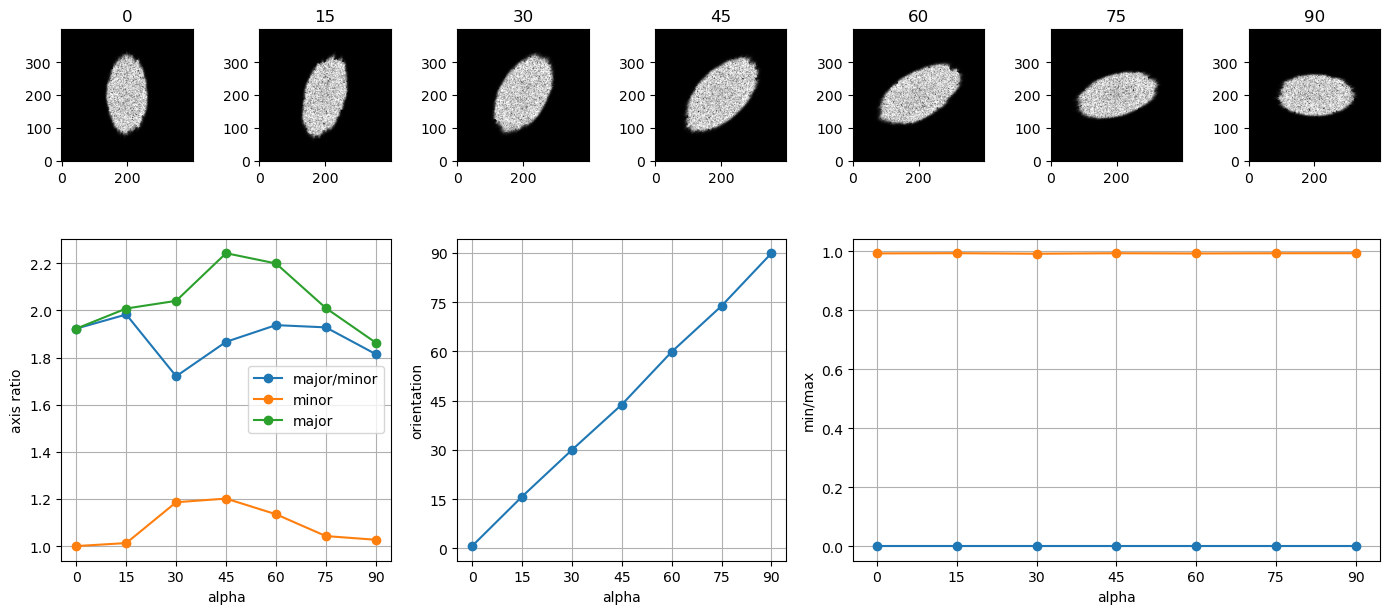

In [6]:

fig, axs = plt.subplot_mosaic([[f'{i}' for i in range(7)],
                               ['axis_ratio'] * 2 + ['orientation']*2 +
                               ['min_max'] * 3],
                               figsize=(14, 7))

mins = []
maxs = []
for i in range(len(alphas)):
    ax = axs[f'{i}']
    ax.imshow(images_10[i], cmap='gray', origin='lower')
    ax.set_title(f'{np.degrees(alphas[i]):.0f}')

    mins.append(images_10[i].min())
    maxs.append(images_10[i].max())
    

ax = axs['axis_ratio']
ax.plot(out_10['alpha'], out_10['axis_ratio'], 'o-', label='major/minor')
ax.plot(out_10['alpha'], out_10['minor_axis_length'] / out_10['minor_axis_length'].min(), 'o-', label='minor')
ax.plot(out_10['alpha'], out_10['major_axis_length'] / out_10['minor_axis_length'].min(), 'o-', label='major')
ax.set_xlabel('alpha')
ax.set_ylabel('axis ratio')
ax.set_xticks(np.degrees(alphas))
ax.grid(True)
ax.legend()

out_10.loc[out_10['orientation'] < 0, 'orientation'] += 180

orientation = out_10['orientation'].values
orientation[orientation > 90] = 180 - orientation[orientation > 90]

ax = axs['orientation']
ax.plot(out_10['alpha'], orientation, 'o-')
ax.set_xlabel('alpha')
ax.set_ylabel('orientation')
ax.set_xticks(np.degrees(alphas))
ax.set_yticks(np.degrees(alphas))
ax.grid(True)

ax = axs['min_max']
ax.plot(np.degrees(alphas), mins, 'o-', label='min')
ax.plot(np.degrees(alphas), maxs, 'o-', label='max')
ax.set_xlabel('alpha')
ax.set_ylabel('min/max')
ax.set_xticks(np.degrees(alphas))
ax.grid(True)

plt.tight_layout()
plt.show()

[]


IndexError: index 0 is out of bounds for axis 0 with size 0

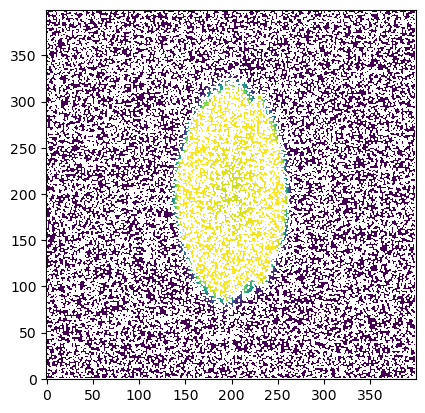

In [7]:
i = 0
y, x = np.where(images_10[i] > 1.001)

print(images_10[i][x, y])

im = images_10[i].copy()
im[im == 0] = np.nan

plt.figure()
plt.imshow(im, cmap='viridis', origin='lower')
plt.ylim([y[0]-10, y[0]+10])
plt.xlim([x[0]-10, x[0]+10])
plt.plot(x, y, 'rx')
plt.colorbar()
plt.show()

In [95]:
xx, yy = np.meshgrid(np.arange(n//2), np.arange(n//2))

coords = np.column_stack([xx.ravel(), yy.ravel()])

selected_coords = coords[np.random.choice(coords.shape[0],
                                          size=int(0.2 * coords.shape[0]),
                                          replace=False)]
selected_coords *= 2

# add 3 points around the coord in selected_coords
selected_coords = np.row_stack([selected_coords,
                                selected_coords + np.array([1, 0]),
                                selected_coords + np.array([0, 1]),
                                selected_coords + np.array([1, 1])])

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import pandas as pd

import finitewave as fw

# number of nodes on the side
n = 400

# alphas = np.radians(np.arange(0, 91, 15))
alpha = np.radians(0)
# loop over different anisotropy coefficients
d = 0.
tissue = fw.CardiacTissue2D([n, n])
# create a mesh of cardiomyocytes (elems = 1):
tissue.mesh = np.ones([n, n])
tissue.mesh[np.random.random([n, n]) < d] = 2
# tissue.mesh[tuple(selected_coords.T)] = 2
# tissue.mesh[n//4: n//3, n//4: n//3] = 2
tissue.add_boundaries()
# add fibers orientation vectors
tissue.fibers = np.zeros([2, n, n])
tissue.fibers[0] = np.cos(alpha)
tissue.fibers[1] = np.sin(alpha)
# add numeric method stencil for weights computations
tissue.stencil = fw.AsymmetricStencil2D()
tissue.D_al = 1
tissue.D_ac = tissue.D_al

# create model object:
aliev_panfilov = fw.AlievPanfilov2D()
# set up numerical parameters:
aliev_panfilov.dt = 0.001
aliev_panfilov.dr = 0.1
aliev_panfilov.t_max = 0.001
# set up stimulation parameters:
stim_sequence = fw.StimSequence()
stim_sequence.add_stim(fw.StimVoltageCoord2D(0, 1, 1, 3, 1, n-1))
stim_sequence.add_stim(fw.StimVoltageCoord2D(50, 1, 1, n-1, 1, n//2))
# add the tissue and the stim parameters to the model object:
aliev_panfilov.cardiac_tissue = tissue
aliev_panfilov.stim_sequence = stim_sequence

aliev_panfilov.run()

Running AlievPanfilov2D: 100%|██████████| 1/1 [00:00<00:00, 153.44it/s]


In [4]:
tissue.weights[50, 50]

array([0. , 0.1, 0. , 0.1, 0.6, 0.1, 0. , 0.1, 0. ])

In [141]:
aliev_panfilov.t_max = 30
aliev_panfilov.run(initialize=False)

Running AlievPanfilov2D: 100%|██████████| 3000/3000 [00:02<00:00, 1399.24it/s]


In [142]:
%matplotlib qt

i = 0
u = aliev_panfilov.u.copy()
# y, x = np.unravel_index(np.argmin(u), u.shape)
y, x = np.where(u < -0.01)

print(y, x)

print(u[x, y])

u[tissue.mesh != 1] = np.nan

plt.figure()
plt.imshow(u, cmap='viridis', origin='lower')
# plt.ylim([y-10, y+10])
# plt.xlim([x-10, x+10])
plt.plot(x, y, 'rx')
plt.colorbar()
plt.show()

[] []
[]
